In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# load data 
df = pd.read_csv("ObesityDataSet-1.csv")

In [11]:
# collapse the obesity level into 4 categories
collapse_map = {
    'Insufficient_Weight': 'Insufficient Weight',
    'Normal_Weight':      'Normal Weight',
    'Overweight_Level_I':  'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I':      'Obese',
    'Obesity_Type_II':     'Obese',
    'Obesity_Type_III':    'Obese'
}

# apply map
df['NObeyesdad'] = df['NObeyesdad'].map(collapse_map)

# Check counts of each class
print(y.value_counts())



Obese                  972
Overweight             580
Normal Weight          287
Insufficient Weight    272
Name: NObeyesdad, dtype: int64


/Users/zoehendershot/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zoehendershot/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zoehendershot/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zoehendershot/anaconda3/lib/python3.

▶ Best max_depth: 10

▶ Tune set classification report:

                     precision    recall  f1-score   support

Insufficient Weight       0.81      0.81      0.81        27
      Normal Weight       0.76      0.55      0.64        29
              Obese       0.80      0.82      0.81        97
         Overweight       0.63      0.69      0.66        58

           accuracy                           0.75       211
          macro avg       0.75      0.72      0.73       211
       weighted avg       0.75      0.75      0.75       211



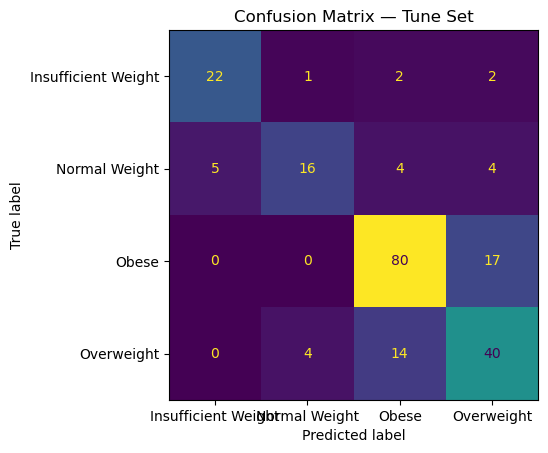


▶ Feature importances:

Age                               0.237488
family_history_with_overweight    0.119301
FCVC                              0.110346
NCP                               0.092545
MTRANS                            0.083803
CAEC                              0.079217
TUE                               0.063374
Gender                            0.048918
FAF                               0.048687
CALC                              0.036983
dtype: float64

▶ Test set classification report:

                     precision    recall  f1-score   support

Insufficient Weight       0.74      0.85      0.79        27
      Normal Weight       0.52      0.55      0.53        29
              Obese       0.88      0.84      0.86        98
         Overweight       0.65      0.64      0.64        58

           accuracy                           0.75       212
          macro avg       0.70      0.72      0.71       212
       weighted avg       0.75      0.75      0.75       212



In [ ]:
# get target + feature arrays
X = df.drop("NObeyesdad", axis=1)
y = df["NObeyesdad"]
X = df.drop(columns=['Height', 'Weight', 'NObeyesdad'])  # Features
y = df['NObeyesdad']  # Target


# encode target using 0 through 3 for the levels
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y) 

# encode categorical features 
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include="object"):
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# train test split (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y_encoded,
    train_size=0.80,
    stratify=y_encoded,
    random_state=42
)
X_tune, X_test, y_tune, y_test = train_test_split(
    X_temp, y_temp,
    train_size=0.50,
    stratify=y_temp,
    random_state=42
)

# use max_depth for hyperparameter, set up scoring metrics
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scoring = ["precision_macro", "f1_macro", "balanced_accuracy"]
dt = DecisionTreeClassifier(random_state=42)
param_grid = {"max_depth": range(1, 11)}

# grid search
grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",
    cv=cv,
    n_jobs=-1
)

# fit to train
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_
print("▶ Best max_depth:", best_dt.get_params()["max_depth"])

# evaluate on tune
y_tune_pred = best_dt.predict(X_tune)
print("\n▶ Tune set classification report:\n")
print(classification_report(y_tune, y_tune_pred, target_names=le_y.classes_))

# confusion matrix for tune
ConfusionMatrixDisplay.from_estimator(
    best_dt, X_tune, y_tune,
    display_labels=le_y.classes_,
    colorbar=False
)
plt.title("Confusion Matrix — Tune Set")
plt.show()

# check feature importances
importances = pd.Series(best_dt.feature_importances_, index=X_encoded.columns)
print("\n▶ Feature importances:\n")
print(importances.sort_values(ascending=False).head(10))

# evaluate on test set
y_test_pred = best_dt.predict(X_test)
print("\n▶ Test set classification report:\n")
print(classification_report(y_test, y_test_pred, target_names=le_y.classes_))
